In [14]:
import xmltodict
import pandas as pd
import os
import re
import json
from datetime import datetime as dt
import subprocess
import concurrent.futures

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.evaluation.rouge import rouge_n
from collections import namedtuple

## Adjust utils.py functions to the windows system (omitted)

In [16]:
LEGISLATION_MAP = {
    'HR': 'Bills',
    'S': 'Bills',
    'HJRES': 'Joint Resolutions',
    'SJRES': 'Joint Resolutions',
    'HCONRES': 'Concurrent Resolutions',
    'SCONRES': 'Concurrent Resolutions',
    'HRES': 'Simple Resolutions',
    'SRES': 'Simple Resolutions'
}
defpath = 'C:\\Users\\Kunyi Liu\\Desktop\\H\\study\\Automatic Summarization of Congressional Bils\\data'

In [41]:
def walk_dirs(path):
    seen = set()
    for root, dirs, files in os.walk(path, topdown=False):
        if dirs:
            parent = root
            while parent != defpath:
                seen.add(parent)
                parent = os.path.dirname(parent)
        for d in dirs:
            d = os.path.join(root, d)

            if d not in seen:
                b_dir = d
                d = d.split('\\', 7)[-1]

                if len(d.split('\\')) > 6:
                    b_version = d.split('\\')[-1].upper()
                else:
                    b_version = 'N/A'
                b_subtype = d.split('\\')[4].upper()
                b_type = LEGISLATION_MAP[b_subtype]
                b_number = d.split('\\')[5].upper()

                summary_dir = defpath + '\\'+ '\\'.join(x for x in d.rsplit('\\')[1:6]) + "\\data.json"
                try:
                    with open(summary_dir) as json_data:
                        j = json.load(json_data)
                    if j['summary']:
                        b_summary = 1
                    else:
                        b_summary = 0
                except FileNotFoundError:
                    print('No data.json file: {}'.format(summary_dir))
                    b_summary = 0

                b_congress = d.split('\\')[2]
                b_id = b_congress+'_'+b_number+'_'+b_version

                data_dict = {
                    'Directory': b_dir, 'Type': b_type, 'Subtype': b_subtype, 'Number': b_number,
                    'Version': b_version, 'Summary': b_summary, 'ID': b_id, 'Congress': b_congress
                }
                # generator of dicts
                yield data_dict

In [47]:
def load_data(congress_number, hrsonly=None):
    # preliminary step for budget only bills selection
    # Bills
    path = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/data'
    INDIR_HR = path + '/data/'+congress_number+'/bills/hr'
    INDIR_S = path + '/data/'+congress_number+'/bills/s'

    # Concurrent Resolutions
    INDIR_HCONRES = path + '/data/'+congress_number+'/bills/hconres'
    INDIR_SCONRES = path + '/data/'+congress_number+'/bills/sconres'

    # Joint Resolutions
    INDIR_HJRES = path + '/data/'+congress_number+'/bills/hjres'
    INDIR_SJRES = path + '/data/'+congress_number+'/bills/sjres'

    # Simple Resolutions
    INDIR_HRES = path + '/data/'+congress_number+'/bills/hres'
    INDIR_SRES = path + '/data/'+congress_number+'/bills/sres'

    if hrsonly:
        indirs = [INDIR_HR, INDIR_S]
        print('Only Load HR and S')
    else:
        indirs = [INDIR_HR, INDIR_S,
                     INDIR_HCONRES, INDIR_SCONRES,
                     INDIR_HJRES, INDIR_SJRES,
                     INDIR_HRES, INDIR_SRES
           ]

    data = []

    for i in indirs:
        i = i.replace('/','\\')
        print('Processing {}'.format(i))
        for d in walk_dirs(i):
            data.append(d)

    df = pd.DataFrame(data)
    print('Number of rows: {}'.format(len(df)))
    print('Number of unique bills: {}'.format(len(df.Number.unique())))

    return df

In [19]:
def get_recent_bills(with_summary):
    for bill_no in with_summary.Number.unique():
        # This version is the official copy of the amendment to a bill or joint resolution as passed, different
        df = with_summary[with_summary.Number == bill_no][with_summary.Version != 'EAS']
        if len(df) > 1:
            try:
                # ENR - final version, Enrolled as Agreed to or Passed by Both House and Senate
                if 'ENR' in list(df.Version):
                    idx = with_summary[with_summary.Number == bill_no][with_summary.Version == 'ENR'].index
                else:
                    all_date_info = []
                    for folder_path in df.Directory:
                        # .. hr10\text-versions\eh or hr10\text-versions\ih
                        date_info = {}
                        with open(folder_path+'/document.xml', encoding="utf8") as f:
                            dict1 = xmltodict.parse(f.read())
                        version = folder_path.split('\\')[-1]
                        date_info['version'] = version
                        if 'bill' in dict1.keys():
                            bill = dict1['bill']
                            date = None
                            if 'form' in bill.keys():
                                form = bill['form']
                                if 'action' in form.keys():
                                    action = form['action']
                                    if isinstance(action, list):
                                        action_dict = action[0]
                                    else:
                                        action_dict = action
                                    if '@date' in action_dict.keys():
                                        date = action_dict['@date']
                                    else:
                                        str_date = action_dict['action-date']
                                        if isinstance(str_date, str):
                                            date = dt.strftime(dt.strptime(str_date, '%B %d, %Y'), '%Y%m%d')
                                        elif isinstance(str_date, dict):
                                            date = str_date['@date']
                                        else:
                                            print('str date', str_date)
                            if date == None and 'attestation' in bill.keys():
                                date = bill['attestation']['attestation-group']['attestation-date']['@date']
                        if date == None:
                            print('here dict', folder_path, dict1, '\n')
                        if date != None:
                            date_info['date'] = date
                        else:
                            print(folder_path)
                        all_date_info.append(date_info)
                        
                    df2 = pd.DataFrame(all_date_info, index=range(len(all_date_info)))
                    to_use = df2.sort_values('date', ascending=False)['version'][0].upper()
                    idx = with_summary[with_summary.Number == bill_no][with_summary.Version == to_use].index
            except:
                ## in 114 and 113th data, part of them don't have document.xml
                idx = df[:1].index
        else:
            idx = with_summary[with_summary.Number == bill_no].index
        with_summary.loc[idx, 'to_use'] = 1
    return with_summary

In [39]:
def dedup_filter_bills(df):
    ##### run after loading data , with get_recent_bills #########
    print('Remove bills with no bill text: {}'.format(len(df[df.Version == 'N/A'])))
    with_bill_text = df[df.Version != 'N/A'].copy()
    # print('Number bills with bill texts: {}'.format(len(with_bill_text)))
    print('Remove bills with no summary: {}'.format(len(with_bill_text[with_bill_text.Summary == 0])))
    with_summary = with_bill_text[with_bill_text.Summary > 0].copy()
    # print('Number of bills left: {}'.format(len(with_summary)))

    # print('Number of unique bills with bill text: {}'.format(len(with_bill_text.Number.unique())))
    print('Getting most recent version for duplicated bills')
    with_summary['to_use'] = 0
    recents_marked = get_recent_bills(with_summary)
    unique_bills = recents_marked[recents_marked.to_use == 1]
    print('Number of unique bills: {}'.format(len(unique_bills)))
    return unique_bills


In [80]:
def clean_bill(text):
    try:
        split = re.split(r'(?i)\sAN\sACT\s{3,}|\sA\sBIL[L]*\s{2,}|\sA*\s[A-Z]*\sRESOLUTION\s{3,}', text)
        if len(split) > 1:
            text1 = split[1]
        elif len(text.split('In the House of Representatives, U. S.,')) > 1:
            text1 = text.split('In the House of Representatives, U. S.,')[1]
        else:
            text1 = text.split('_______________________________________________________________________')[1]
        if len(re.split(r'\s{2,}Passed the (Senate |House of Representatives )', text1)) > 1:
            print('XXXXXXXXXXXXXXXXXXxx')
        text21 = re.split(r'\s{2,}Passed the (Senate |House of Representatives )', text1)[0] # remove words after 'Attest:'
        text22 = re.split(r'\s{2,}Attest:\s{2,}', text21)[0] # remove words after 'Attest:'
        text23 = re.split(r'\s{2,}(Union |House )*Calendar No\.\s\d+\s{2,}', text22)[0] #
        text24 = re.split(r'\s{2,}Speaker of the House of Representatives\.\s{2,}', text23)[0]
        text3 = re.sub(r'[ ][\n][ ]+', r' ', text24) # somtimes one sentence may be break into multiple lines
        text4 = re.sub(r'\<all\>\s*$', r'', text3) # remove <all> in the end
        text5 = re.sub(r'\s', r' ', text4) # replace all kinds of white space (\n\t ) with ' '
        text6 = text5.replace('--', ' -- ') # add axtra space around --
        text7 = re.sub(r',\s+SECTION 1.', r'. SECTION 1', text6) # replace ',' before section 1 with '.'
        text8 = re.sub(r'(?i)(\sSEC)(\.)(\s\d)(\s*\.)', r'\1TION\3 ', text7) # replace 'SEC. x.' with 'SECTION x '
#         text9 = re.sub(r'Calendar No[\d\w\s\.]+$', r'', text8) # remove extra Calendar No.... in the end
        text10 = text8.replace(';', '.') # convert clause into sentences
        text11 = text10.replace("''. ", " ")
        text12 = text11.replace('--', ' ')
        text13 = text12.replace('``', " ")
        text14 = text13.replace("''", " ")
        return text14.strip()
    except:
        print('!!! Error at cleaning text:')
        print(text)
#         return ' '
        raise

In [33]:
def clean_summary(text):
    summary = ''
    text1 = re.sub(r'\(This measure has not been amended[\w\s\d,\.]+\)', ' ', text)
    # each line represents one sentence
    for s in text1.split('\n'):
        if s.strip().rstrip():
            summary += s+'\n'
    return summary

In [82]:
def split_file(data, cp='"*"'):
    ## with clean_summary and clean_bill
    i, row = data
    ## row['Congress'] - 115
    outdir = os.path.join(defpath, 'out', row['Congress'])

    indir_b = os.path.join(row['Directory'], 'document.txt')

    filename_b = 'BILL' + '_' + row['ID']
    tmp_b = os.path.join(outdir, filename_b + '.txt')
    out_b = os.path.join(outdir, filename_b + '.out')

    with open(indir_b, 'r', encoding="utf8") as f:
        text_b = f.read()
    
    # BILL_115_hr1_ih holds cleaned bill
    with open(tmp_b, 'w', encoding="utf8") as f:
        print(indir_b)
        f.write(clean_bill(text_b))

    command = ['java', '-cp', cp, '-mx5g', 'edu.stanford.nlp.process.PTBTokenizer', tmp_b]
    
    # BILL_115_hr1_ih.out holds bills processed by standford nlp
    with open(out_b, "w", encoding="utf8") as outfile:
        subprocess.run(command, stdout=outfile)

    with open(out_b, "r+", encoding="utf8") as f:
        text_b = f.read()
        text_new = text_b.replace('-LRB-', '(').replace('-RRB-', ')')
        # rewrite the file
        f.seek(0)
        f.write(text_new)
        f.truncate()

    os.remove(tmp_b)

    indir_s = os.path.join(row['Directory'], '..', '..', 'data.json')
    filename_s = 'SUMMARY' + '_' + row['ID']
    # tmp_s = os.path.join(outdir, filename_s)
    out_s = os.path.join(outdir, filename_s + '.out')

    # split summary
    with open(indir_s, 'r', encoding="utf8") as f:
        text_s = json.load(f)['summary']['text']

    with open(out_s, 'w', encoding="utf8") as f:
        f.write(clean_summary(text_s))


In [67]:
def concurrent_split(df):
    counts = range(1, len(df)+1)
    outdir = os.path.join('./out', df[:1].Congress[0])
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    #with concurrent.futures.ProcessPoolExecutor() as executor:
    for i, _ in zip(counts, map(split_file, df.iterrows())):
        if i % 100 == 0:
            print('Spliting file: {}/{} bills'.format(i, len(df)))


In [61]:
print('-- 115th Congress')
df_115 = load_data('115', hrsonly=1) # load_data('115') will load all the bills
unique_115 = dedup_filter_bills(df_115)

-- 115th Congress
Only Load HR and S
Processing C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr
Processing C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s
Number of rows: 7867
Number of unique bills: 6401
Remove bills with no bill text: 78
Remove bills with no summary: 2357
Getting most recent version for duplicated bills


C:\Users\Kunyi Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Kunyi Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Kunyi Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Number of unique bills: 4114


In [83]:
%%time
concurrent_split(unique_115)

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr10\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr100\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1000\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1001\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1002\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1003\text-versions\ih\document.tx

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1054\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1055\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1056\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1058\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1059\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr106\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1060\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1111\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1112\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1113\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1114\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1115\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1116\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1117\text-versions\enr\document.txt
C:\Users\Kun

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1169\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr117\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1170\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1171\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1172\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1173\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1174\text-versions\eh\document.txt
XXXXXXXXXXXXXX

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1222\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1223\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1224\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1225\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1226\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1227\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1228\text-versions\enr\document.txt
C:\Users\Kun

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1278\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1279\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr128\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1280\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1281\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1282\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1283\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr134\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1340\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1341\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1342\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1343\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1344\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1345\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1397\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1399\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr140\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1400\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1401\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1402\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1403\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1454\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1455\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1456\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1457\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1458\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1459\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr146\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1509\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr151\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1510\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1512\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1513\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1514\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1515\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1570\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1571\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1572\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1573\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1574\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1575\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1577\text-versions\ih\document.txt
C:\Users\Kuny

XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr163\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1630\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1631\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1632\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1633\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1634\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1635\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1687\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1688\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1689\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr169\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1690\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
Spliting file: 700/4114 bills
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1691\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1752\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1753\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1754\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1755\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1756\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1757\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1759\text-versions\ih\document.txt
C:\Users\Kuny

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1817\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1818\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1819\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr182\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1820\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1821\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1822\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1885\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1886\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1887\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1888\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1889\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr189\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1891\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1952\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1956\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1957\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1959\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr196\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1960\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr1961\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2020\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2021\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2024\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2027\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2029\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr203\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2030\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr21\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr210\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2100\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2102\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2103\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2105\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2106\text

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2167\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2168\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2169\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr217\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2171\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2172\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2173\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2228\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2229\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr223\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2230\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2231\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2233\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2234\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2300\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2302\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2303\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2305\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2306\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2307\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2309\text-versions\ih\docum

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2371\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2372\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2373\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2374\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2375\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2377\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2378\text-versions\ih\docum

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2443\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2448\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2449\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr245\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2450\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2452\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2453\text-versions\eh\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr253\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2530\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2531\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2532\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2533\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2534\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2535\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2613\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2615\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2616\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2618\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr262\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2623\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2624\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2770\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2772\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2773\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2774\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2777\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2778\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2779\text-versions\ih\docum

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2848\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2849\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr285\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2852\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2853\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2856\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2857\text-versions\eh\document.txt
XXXXXXXXXXXXXX

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2934\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2939\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr294\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2940\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2941\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2942\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr2943\te

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3021\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3023\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3024\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3026\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr303\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3031\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3032\text-versions\ih\document.txt
C:\Users\Kuny

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3122\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3124\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3125\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3126\text-versions\ih\document.txt
Spliting file: 1800/4114 bills
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3129\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr313\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr321\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3210\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3213\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3217\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3219\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr322\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3220\te

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr332\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3320\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3322\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3323\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3324\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr333\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3331\text-versions\ih\document.txt
C:\Users\Kunyi 

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3460\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3461\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3462\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3467\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3469\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr347\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3471\text-versions\ih\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3591\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3595\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3597\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3598\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3599\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr36\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr360\text-versions\ih\document

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3702\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3705\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3707\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr371\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3711\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3719\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr372\text-versions\eh\document.txt
XXXXXXXXXXXXXXX

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3872\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3873\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3878\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3879\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr388\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3881\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr3883\text-versions\ih\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr410\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr411\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr4110\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr4113\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr412\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr4120\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr4126\text-versions\ih\document.txt
C:\Users\Kunyi L

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr453\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr454\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr455\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr456\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr457\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr458\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr459\text-versions\ih\document.txt

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr507\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr508\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr509\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr51\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr510\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr511\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr512\text-versions\eh\document.txt

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr560\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr561\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr562\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr563\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr564\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr565\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr566\text-versions\ih\document.txt

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr616\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr617\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr618\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr619\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr62\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr620\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr621\text-versions\ih\document.txt


C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr669\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr67\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr670\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr671\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr672\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr673\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr674\text-versions\ih\document.txt


C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr720\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr721\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr722\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr723\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr724\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr725\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr726\text-ver

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr775\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr776\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr777\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr778\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr779\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr78\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr780\text-versions\ih\document.txt


C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr832\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr833\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr834\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr835\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr836\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr837\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr838\text-versions\ih\document.txt
C:\Users\Kunyi Liu\D

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr890\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr891\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr892\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr893\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr894\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr895\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr896\text-versions\ih\document.txt
C:\Users\Kunyi Liu\D

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr948\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr949\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr95\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr950\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr951\text-versions\eh\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr952\text-versions\ih\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\hr\hr953\text-vers

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1000\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1001\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1003\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1005\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1006\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1007\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s101\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1182\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1183\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1186\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1187\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1188\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s119\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1190\text-versions\is\document.txt
C:\User

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1266\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1267\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s127\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1271\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1274\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1278\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s128\text-versions\is\document.txt
C:\Users

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s136\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1361\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1364\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1366\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1367\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1369\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s137\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1482\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1483\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1485\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1486\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1487\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1489\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s149\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H

Spliting file: 3200/4114 bills
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1615\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1616\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1617\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1618\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1619\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s162\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1620\text-versions\is\document

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1725\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1728\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1729\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s173\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1732\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1735\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1737\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s19\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s190\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1906\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1908\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s191\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s192\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s1920\text-versions\is\document.txt
C:\Users\K

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s225\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s226\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s227\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s228\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s229\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s23\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s230\text-versions\is\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s282\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s283\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s284\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s285\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s286\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s287\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s288\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s34\text-versions\is\document.txt
Spliting file: 3500/4114 bills
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s340\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s341\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s342\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s343\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s344\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s345\text-versions\is\document.txt
C:\U

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s400\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s401\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s402\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s403\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s404\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s405\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s406\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s46\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s460\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s461\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s462\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s463\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s464\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s465\text-versions\is\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s521\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s522\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s523\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s524\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s525\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s526\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s527\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s580\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s581\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s583\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s584\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s585\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s586\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s587\text-versions\is\document.txt
C:\Users\Ku

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s64\text-versions\is\document.txt
Spliting file: 3800/4114 bills
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s640\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s641\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s643\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s644\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s645\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s647\text-versions\is\document.txt
C:\U

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s706\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s707\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s708\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s709\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s71\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s710\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s711\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s765\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s767\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s769\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s77\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s770\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s772\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s773\text-versions\is\docume

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s834\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s835\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s836\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s839\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s84\text-versions\enr\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s840\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s841\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s91\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s910\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s911\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s912\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s916\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s917\text-versions\es\document.txt
XXXXXXXXXXXXXXXXXXxx
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s918\text-versions\is\document.txt
C:\Users\Kunyi

C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s980\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s983\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s984\text-versions\is\document.txt
Spliting file: 4100/4114 bills
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s985\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s986\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s988\text-versions\is\document.txt
C:\Users\Kunyi Liu\Desktop\H\study\Automatic Summarization of Congressional Bils\data\data\115\bills\s\s989\text-versions\is\document.txt
C:\

## Add features like subjects and related_bills 

In [153]:
def add_features(df):
    # attach features from data.json (summary) to bills table
    subjects, subjects_top_term, related_bills, url, official_title = [], [], [], [], []
    for ind, row in df.iterrows():
        try:
            tpath = row.Directory.rsplit('\\',2)[0]
            with open(os.path.join(tpath, 'data.json'), encoding = "utf8") as json_data:
                j = json.load(json_data)
            # add list: ['subjects', 'url', 'official_title', 'subjects_top_term']:
            subjects.append(j['subjects'])
            subjects_top_term.append(j['subjects_top_term'])
            url.append(j['url'])
            official_title.append(j['official_title'])
            # f related_bills
            if isinstance(j['related_bills'], list):
                related_bills.append([_['bill_id'].upper() for _ in j['related_bills']])
            else:
                print(j['related_bills'])
                related_bills.append(j['related_bills']['bill_id'])
        except Exception as e:
            print("Error is {}".format(e))
            
    df['Subjects'] = subjects
    df['Subjects_top_term'] = subjects_top_term
    df['Related_Bills'] = related_bills
    df['URL'] = url
    df['Official_title'] = official_title
    return df

In [155]:
unique_115_add = add_features(unique_115)

### Try to choose budget subjects

In [319]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

In [315]:
all_sub = [] # record all subjects
ret = unique_115_add.apply(lambda row: all_sub.extend(row['Subjects'][:]), axis = 1)
all_sub = set(all_sub)
top_words = ['bank', 'budget', 'business', 'credit', 'tax', 'taxes', 'finance', 'trade', 'trading', 'marketing']
#top_words = ['budget']
bud_sub = [_ for _ in all_sub if set(top_words).intersection(_.lower().split())]

In [316]:
text = ''
unique_115_add['Is_busget'] = 0
for ind, row in unique_115_add.iterrows():
    if set(row['Subjects']).intersection(set(bud_sub)):
        text = " ".join([text, row['Subjects_top_term']])
        unique_115_add.set_value(ind, 'Is_busget', 1)
text = text.strip()

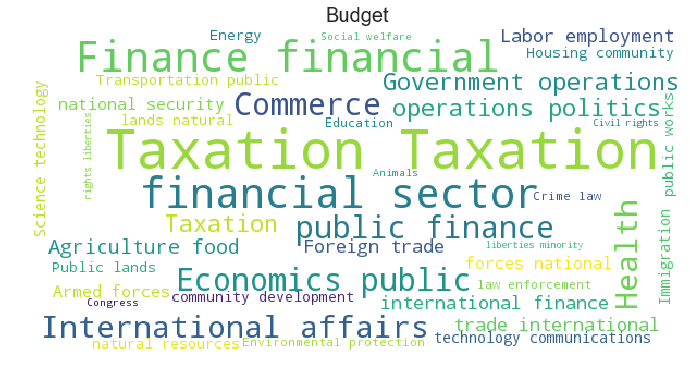

In [213]:
# show subject top terms
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300,
                      max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Budget", fontsize=20)
plt.axis("off")
plt.show()

### Related Bills Network

In [235]:
# if there is bills from 113 and 114
all_rel = [] # record all subjects
ret = unique_115_add.apply(lambda row: all_rel.extend(row['Related_Bills'][:]), axis = 1)
print('Related bills from 113 or 114: %s'%[_ for _ in all_rel if _.split('-')[-1] != '115'])
print('Construct Edges of the network')
edges = []
for ind, row in unique_115_add.iterrows():
    if row['Related_Bills'] != []:
        temp_edge = [(row['Number'], _.split('-')[0].upper()) for _ in row['Related_Bills']]
    else:
        temp_edge = []
    edges += temp_edge

Related bills from 113 or 114: []


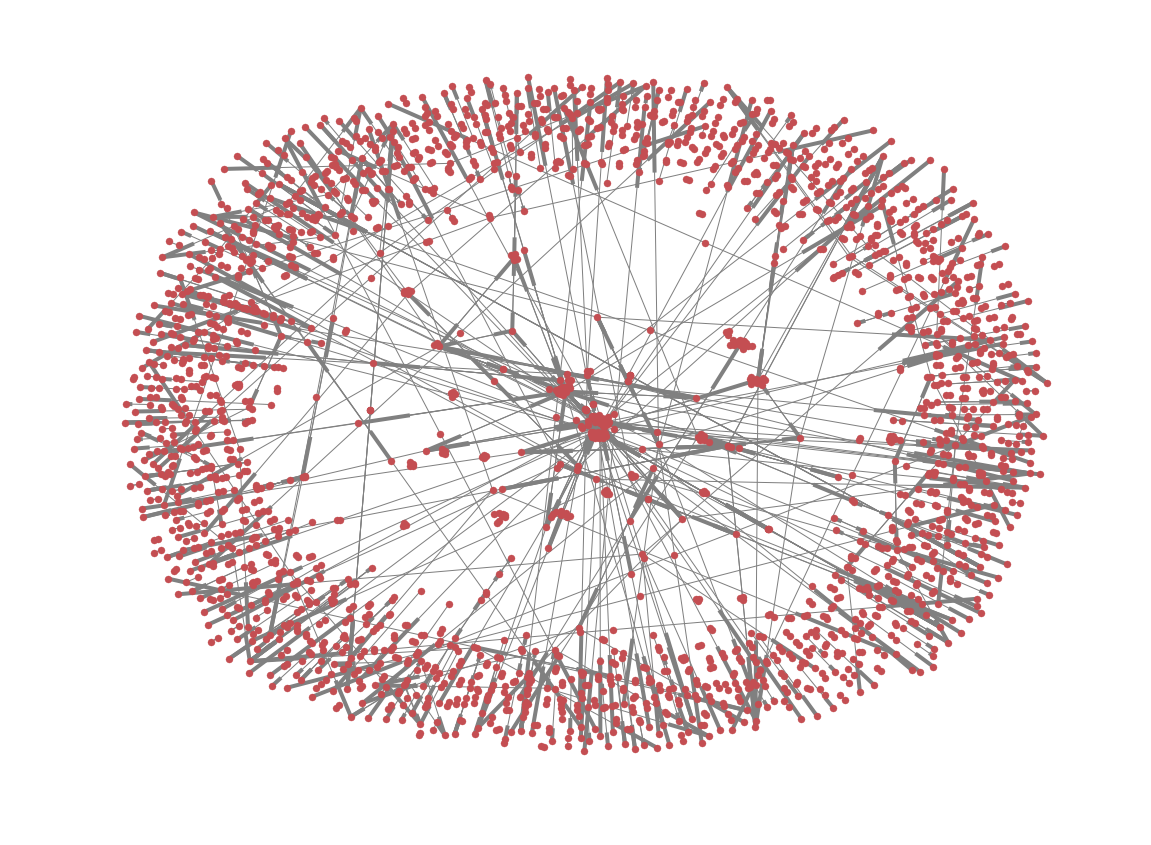

In [318]:
G = nx.DiGraph()
G.add_edges_from(edges)
# Need to create a layout when doing
# separate calls to draw nodes and edges
plt.figure(figsize=(20,15))
values = unique_115_add['Is_busget'].values
f = lambda x: 'red' if x == 1 else 'blue'
values = [_ for _ in map(f, values)]

pos = nx.spring_layout(G)
## set budget type with colors?
#nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color = values , node_size = 50)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 50)
#nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist= edges, edge_color='gray', arrows=True)
plt.axis("off")
plt.show()